In [1]:
%matplotlib inline
%matplotlib widget

# Import appropriate specalist modules
import sys

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style
import math

import scipy
import scipy.interpolate as interp
import scipy.stats as sps
from scipy import stats, optimize
from scipy.interpolate import RegularGridInterpolator, LinearNDInterpolator
from scipy.optimize import leastsq, least_squares, curve_fit

import zipfile

import glob
import io

import astropy
import astropy.units as u
from astropy.io import fits
from astropy import table
from astropy.table import Table
from astropy.table import join_skycoord
from astropy.coordinates import SkyCoord
from astropy.utils.data import get_pkg_data_filename
from astropy.wcs import WCS
from astropy.convolution import Gaussian1DKernel, convolve, Box1DKernel
from astropy.time import Time

import statistics as stat


from csv import reader
import re

import specutils
from specutils import Spectrum1D, SpectralRegion
from specutils.analysis import snr, snr_derived, line_flux, equivalent_width, fwhm
from specutils.fitting import fit_generic_continuum

from collections import namedtuple

import pprint

from natsort import natsorted

import lightkurve as lk




# Set plot defaults
plt.rc('figure', figsize=(7, 7))
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.titlesize'] = 'medium'

def format_tickmarks(ax):
    ax.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True)
    ax.tick_params(which='both', width=1.1)
    ax.tick_params(which='major', length=8)
    ax.tick_params(which='minor', length=4)

def format_tickmarks_1(ax):
    ax.tick_params(which='both', direction='in', bottom=True, top=True, left=True)
    ax.tick_params(which='both', width=1.1)
    ax.tick_params(which='major', length=8)
    ax.tick_params(which='minor', length=4)

def format_tickmarks_2(ax):
    ax.tick_params(which='both', direction='in', bottom=True, top=True, right=True)
    ax.tick_params(which='both', width=1.1)
    ax.tick_params(which='major', length=8)
    ax.tick_params(which='minor', length=4)

def add_legend(ax, no_of_lines, marker_size, loc='lower right'):
    '''
    Add a legend to the plot showing the elements and ions associated to the spectral lines.
    
    Arguments:
    ax = axis which to plot the legend
    no_of_lines = the number of different spectral lines which are plotted on the graph
    loc = position on plot (default is on the upper right)
    '''
    
    handles, labels = plt.gca().get_legend_handles_labels()
    label = dict(zip(labels, handles))
    leg = ax.legend(label.values(), label.keys(), loc=loc, ncol=no_of_lines, fontsize=13, framealpha=1)
    
    for i in leg.legendHandles:
        i.set_linewidth(marker_size)

    return leg



# Set pandas dataframe row and column display
pd.set_option('display.max_rows', 10, 'display.max_columns', None)

# User Functions

In [ ]:
# Colour blind colours

#377eb8 blue
#ff7f00 orange
#4daf4a green
#f781bf pink
#a65628 brown
#984ea3 purple
#999999 grey 
#e41a1c red
#dede00 yellow

In [2]:
def parallax_to_dis(parallax):
    '''
    parallax = parallax [mas]
    '''
    
    D = 1 / (parallax / 1000)
    return D


def abs_mag(m, D):
    '''
    m = apparent magnitude
    D = distance [pc]
    '''
    
    M = m - 5*np.log10(D) + 5
    return M

def CaI_4227(ax):
    '''
    Plot a vertical dashed line where the CaI absorption line is (4226/4227 A).
    
    Arguments:
    ax = axis which to plot the line
    
    '''

    ax.axvline(x=4227, linestyle='-', color='g', alpha=0.35, linewidth=2, label='Ca I')

def CaII_8600(ax):
    '''
    Plot a vertical dashed line where the CaII absorption line is (8600 A).
    
    Arguments:
    ax = axis which to plot the line
    
    '''
    
    ax.axvline(x=8600, linestyle='-', color='g', alpha=0.4, linewidth=2, label='Ca II')

def balmer_lines(lw):
    
    # 656.279	486.135	434.0472	410.1734	397.0075	388.9064

    plt.axvline(x=6562, lw=lw, color='#505050', alpha=0.15, label=r'H$\alpha$')
    plt.axvline(x=4860, lw=lw, color='c', alpha=0.15, label=r'H$\beta$')
    plt.axvline(x=4340, lw=lw, color='y', alpha=0.15, label=r'H$\gamma$')
    plt.axvline(x=4100, lw=lw, color='g', alpha=0.15, label=r'H$\delta$')
    plt.axvline(x=3970, lw=lw, color='r', alpha=0.15, label=r'H$\epsilon$')
    plt.axvline(x=3890, lw=lw, color='b', alpha=0.15, label=r'H$\zeta$')


def H_alpha():
    x=6562
    lw=35
    color='#505050'
    alpha=0.15
    label=r'H$\alpha$'
    xlim = [6462, 6662]
    return x, lw, color, alpha, label, xlim


def H_beta():
    x=4861
    lw=35
    color='c'
    alpha=0.15
    label=r'H$\beta$'
    xlim = [4761, 4961]
    return x, lw, color, alpha, label, xlim

def H_gamma():
    x=4340
    lw=35
    color='y'
    alpha=0.15
    label=r'H$\gamma$'
    xlim = [4240, 4440]
    return x, lw, color, alpha, label, xlim

def H_delta():
    x=4101
    lw=35
    color='g'
    alpha=0.15
    label=r'H$\delta$'
    xlim = [4001, 4201]
    return x, lw, color, alpha, label, xlim

def H_epsilon():
    x=3970
    lw=35
    color='r'
    alpha=0.15
    label=r'H$\epsilon$'
    xlim = [3870, 4070]
    return x, lw, color, alpha, label, xlim

def H_zeta():
    x=3889
    lw=35
    color='b'
    alpha=0.15
    label=r'H$\zeta$'
    xlim = [3789, 3989]
    return x, lw, color, alpha, label, xlim

def plot_Ha_line(axis):
    x, lw, color, alpha, label, xlim = H_alpha()
    axis.axvline(x=x, lw=10, color=color, alpha=alpha, label=r'H$\alpha$')
    axis.legend(fontsize=13, framealpha=1)
    marker_size = 10

def plot_Hb_line(axis):
    x, lw, color, alpha, label, xlim = H_beta()
    axis.axvline(x=x, lw=10, color=color, alpha=alpha, label=r'H$\beta$')
    axis.legend(fontsize=13, framealpha=1)
    marker_size = 10


def ZeemanSplitting(lambda0, B):
    k0 = 1e8 / lambda0
    k_triplet = [k0 + 46.686 * B * m_l for m_l in (-1, 0, +1)]
    return [1e8/k for k in k_triplet]

def radial_velocity(rest_lambda, observed_lambda):
    wavelength_shift = observed_lambda - rest_lambda
    radial_vel = (wavelength_shift/rest_lambda) * (3e+05)
    
    return radial_vel



# User function to load data from a fits file
def load_fits_file(fits_file):
    '''
    Function to load all data from a fits file into a pandas dataframe.
    
    Arguments:
    fits_file = name of the fits file from which data is loaded
    '''
    
    fits_table = Table.read(fits_file, format='fits')
    fits_df = fits_table.to_pandas()
    return fits_df

def read_fits_file_hdr(file):
    file = fits.open(file)
    info = file.info()
    hdr = file[0].header
    
    file.close()
    
    return info, hdr


"""readmultispec.py
Read IRAF (echelle) spectrum in multispec format from a FITS file.
Can read most multispec formats including linear, log, cubic spline,
Chebyshev or Legendre dispersion spectra.
Usage: retdict = readmultispec(fitsfile, reform=True)
Inputs:
fitfile     Name of the FITS file
reform      If true (the default), a single spectrum dimensioned
            [4,1,NWAVE] is returned as flux[4,NWAVE].  If false,
            it is returned as a 3-D array flux[4,1,NWAVE].
Returns a dictionary with these entries:
flux        Array dimensioned [NCOMPONENTS,NORDERS,NWAVE] with the spectra.
            If NORDERS=1, array is [NCOMPONENTS,NWAVE]; if NCOMPONENTS is also
            unity, array is [NWAVE].  (This can be changed
            using the reform keyword.)  Commonly the first dimension
            is 4 and indexes the spectrum, an alternate version of
            the spectrum, the sky, and the error array.  I have also
            seen examples where NCOMPONENTS=2 (probably spectrum and
            error).  Generally I think you can rely on the first element
            flux[0] to be the extracted spectrum.  I don't know of
            any foolproof way to figure out from the IRAF header what the
            various components are.
wavelen     Array dimensioned [NORDERS,NWAVE] with the wavelengths for
            each order.
header      The full FITS header from pyfits.
wavefields  [NORDERS] List with the analytical wavelength
            description (polynomial coefficients, etc.) extracted from
            the header.  This is probably not very useful but is
            included just in case.
History:
Created by Rick White based on my IDL readechelle.pro, 2012 August 15
Apologies for any IDL-isms that remain!
"""

import numpy as np
from astropy.io import fits as pyfits


def nonlinearwave(nwave, specstr, verbose=False):
    """Compute non-linear wavelengths from multispec string
    
    Returns wavelength array and dispersion fields.
    Raises a ValueError if it can't understand the dispersion string.
    """

    fields = specstr.split()
    if int(fields[2]) != 2:
        raise ValueError('Not nonlinear dispersion: dtype=' + fields[2])
    if len(fields) < 12:
        raise ValueError('Bad spectrum format (only %d fields)' % len(fields))
    wt = float(fields[9])
    w0 = float(fields[10])
    ftype = int(fields[11])
    if ftype == 3:

        # cubic spline

        if len(fields) < 15:
            raise ValueError('Bad spline format (only %d fields)' % len(fields))
        npieces = int(fields[12])
        pmin = float(fields[13])
        pmax = float(fields[14])
        if verbose:
            print('Dispersion is order-%d cubic spline') % npieces
        if len(fields) != 15 + npieces + 3:
            raise ValueError('Bad order-%d spline format (%d fields)' % (npieces, len(fields)))
        coeff = np.asarray(fields[15:], dtype=float)
        # normalized x coordinates
        s = (np.arange(nwave, dtype=float) + 1 - pmin) / (pmax - pmin) * npieces
        j = s.astype(int).clip(0, npieces - 1)
        a = (j + 1) - s
        b = s - j
        x0 = a ** 3
        x1 = 1 + 3 * a * (1 + a * b)
        x2 = 1 + 3 * b * (1 + a * b)
        x3 = b ** 3
        wave = coeff[j] * x0 + coeff[j + 1] * x1 + coeff[j + 2] * x2 + coeff[j + 3] * x3

    elif ftype == 1 or ftype == 2:

        # chebyshev or legendre polynomial
        # legendre not tested yet

        if len(fields) < 15:
            raise ValueError('Bad polynomial format (only %d fields)' % len(fields))
        order = int(fields[12])
        pmin = float(fields[13])
        pmax = float(fields[14])
        if verbose:
            if ftype == 1:
                print('Dispersion is order-%d Chebyshev polynomial') % order
            else:
                print('Dispersion is order-%d Legendre polynomial (NEEDS TEST)') % order
        if len(fields) != 15 + order:
            # raise ValueError('Bad order-%d polynomial format (%d fields)' % (order, len(fields)))
            if verbose:
                print('Bad order-%d polynomial format (%d fields)') % (order, len(fields))
                print("Changing order from %i to %i") % (order, len(fields) - 15)
            order = len(fields) - 15
        coeff = np.asarray(fields[15:], dtype=float)
        # normalized x coordinates
        pmiddle = (pmax + pmin) / 2
        prange = pmax - pmin
        x = (np.arange(nwave, dtype=float) + 1 - pmiddle) / (prange / 2)
        p0 = np.ones(nwave, dtype=float)
        p1 = x
        wave = p0 * coeff[0] + p1 * coeff[1]
        for i in range(2, order):
            if ftype == 1:
                # chebyshev
                p2 = 2 * x * p1 - p0
            else:
                # legendre
                p2 = ((2 * i - 1) * x * p1 - (i - 1) * p0) / i
            wave = wave + p2 * coeff[i]
            p0 = p1
            p1 = p2

    else:
        raise ValueError('Cannot handle dispersion function of type %d' % ftype)

    return wave, fields


def readmultispec(fitsfile, reform=True, quiet=False):
    """Read IRAF echelle spectrum in multispec format from a FITS file
    
    Can read most multispec formats including linear, log, cubic spline,
    Chebyshev or Legendre dispersion spectra
    
    If reform is true, a single spectrum dimensioned 4,1,NWAVE is returned
    as 4,NWAVE (this is the default.)  If reform is false, it is returned as
    a 3-D array.
    """

    fh = pyfits.open(fitsfile)
    try:
        header = fh[0].header
        flux = fh[0].data
    finally:
        fh.close()
    temp = flux.shape
    nwave = temp[-1]
    if len(temp) == 1:
        nspec = 1
    else:
        nspec = temp[-2]

    # first try linear dispersion
    try:
        crval1 = header['crval1']
        crpix1 = header['crpix1']
        cd1_1 = header['cd1_1']
        ctype1 = header['ctype1']
        if ctype1.strip() == 'LINEAR':
            wavelen = np.zeros((nspec, nwave), dtype=float)
            ww = (np.arange(nwave, dtype=float) + 1 - crpix1) * cd1_1 + crval1
            for i in range(nspec):
                wavelen[i, :] = ww
            # handle log spacing too
            dcflag = header.get('dc-flag', 0)
            if dcflag == 1:
                wavelen = 10.0 ** wavelen
                if not quiet:
                    print('Dispersion is linear in log wavelength')
            elif dcflag == 0:
                if not quiet:
#                     print('Dispersion is linear')
                    print(' ')
            else:
                raise ValueError('Dispersion not linear or log (DC-FLAG=%s)' % dcflag)

            if nspec == 1 and reform:
                # get rid of unity dimensions
                flux = np.squeeze(flux)
                wavelen.shape = (nwave,)
            return {'flux': flux, 'wavelen': wavelen, 'header': header, 'wavefields': None}
    except KeyError:
        pass

    # get wavelength parameters from multispec keywords
    try:
        wat2 = header['wat2_*']
        count = len(wat2)
    except KeyError:
        raise ValueError('Cannot decipher header, need either WAT2_ or CRVAL keywords')

    # concatenate them all together into one big string
    watstr = []
    for i in range(len(wat2)):
        # hack to fix the fact that older pyfits versions (< 3.1)
        # strip trailing blanks from string values in an apparently
        # irrecoverable way
        # v = wat2[i].value
        v = wat2[i]
        v = v + (" " * (68 - len(v)))  # restore trailing blanks
        watstr.append(v)
    watstr = ''.join(watstr)

    # find all the spec#="..." strings
    specstr = [''] * nspec
    for i in range(nspec):
        sname = 'spec' + str(i + 1)
        p1 = watstr.find(sname)
        p2 = watstr.find('"', p1)
        p3 = watstr.find('"', p2 + 1)
        if p1 < 0 or p1 < 0 or p3 < 0:
            raise ValueError('Cannot find ' + sname + ' in WAT2_* keyword')
        specstr[i] = watstr[p2 + 1:p3]

    wparms = np.zeros((nspec, 9), dtype=float)
    w1 = np.zeros(9, dtype=float)
    for i in range(nspec):
        w1 = np.asarray(specstr[i].split(), dtype=float)
        wparms[i, :] = w1[:9]
        if w1[2] == -1:
            raise ValueError('Spectrum %d has no wavelength calibration (type=%d)' %
                             (i + 1, w1[2]))
            # elif w1[6] != 0:
            #    raise ValueError('Spectrum %d has non-zero redshift (z=%f)' % (i+1,w1[6]))

    wavelen = np.zeros((nspec, nwave), dtype=float)
    wavefields = [None] * nspec
    for i in range(nspec):
        # if i in skipped_orders:
        #    continue
        verbose = (not quiet) and (i == 0)
        if wparms[i, 2] == 0 or wparms[i, 2] == 1:
            # simple linear or log spacing
            wavelen[i, :] = np.arange(nwave, dtype=float) * wparms[i, 4] + wparms[i, 3]
            if wparms[i, 2] == 1:
                wavelen[i, :] = 10.0 ** wavelen[i, :]
                if verbose:
                    print('Dispersion is linear in log wavelength')
            elif verbose:
#                 print('Dispersion is linear')
                print(' ')
        else:
            # non-linear wavelengths
            wavelen[i, :], wavefields[i] = nonlinearwave(nwave, specstr[i],
                                                         verbose=verbose)
        wavelen *= 1.0 + wparms[i, 6]
        if verbose:
            print(' ')
#             print("Correcting for redshift: z=%f") % wparms[i, 6]
    if nspec == 1 and reform:
        # get rid of unity dimensions
        flux = np.squeeze(flux)
        wavelen.shape = (nwave,)
    return {'flux': flux, 'wavelen': wavelen, 'header': header, 'wavefields': wavefields}



def spectrum_object_no_err(wavelength_col, flux_col, wavelength_unit=u.AA, flux_unit=(u.erg * u.cm**-2 * u.s**-1 * u.AA**-1)):
    
    spectrum = Spectrum1D(spectral_axis=u.Quantity(wavelength_col, wavelength_unit), flux=u.Quantity(flux_col, flux_unit))

    return spectrum

def convolve_observed_spectra(flux, FWHM):
    
    sigma = FWHM / np.sqrt(8 * np.log(2))
    g_std = Gaussian1DKernel(stddev=sigma)

    convolved_flux = convolve(np.array(flux), g_std)
    
    return convolved_flux


def continuum_fitted_spectrum(spectrum, wavelength_col, spectrum_edges_and_spec_lines, wavelength_unit=u.AA):

    spectrum_fit = fit_generic_continuum(spectrum, exclude_regions=spectrum_edges_and_spec_lines)
    spectrum_y_continuum_fitted = spectrum_fit(u.Quantity(wavelength_col, wavelength_unit))
    spec_normalised = spectrum / spectrum_y_continuum_fitted
    
    return spectrum_y_continuum_fitted, spec_normalised

def air_to_vac(wavelength):
    """
    Implements the air to vacuum wavelength conversion described in eqn 65 of
    Griesen 2006
    """
    wlum = wavelength
    return (1+1e-6*(287.6155+1.62887/wlum**2+0.01360/wlum**4)) * wavelength

def TBJD_to_BJD(lc):
    lc_time = lc.time + 2457000.0
    lc_BJD = lc_time.value
    
    lc_flux = lc.flux.value
    
    return lc_BJD, lc_flux

def MJD_JD_BTJD_BJD(UTC_ISOT_times):
    t_MJD = Time(UTC_ISOT_times, format='mjd')
    t_JD = Time(t_MJD.jd, format='jd')
    t_BTJD = Time(t_JD.btjd, format='btjd')
    t_BJD = t_BTJD.value + 2457000.0
    
    return t_MJD, t_JD, t_BTJD, t_BJD

<br>
<br>

# Observational Data


- FORS2 2022, Date, file name
    - 14/15-May-2022     2022-05-15T03_39
    - 31/01-Jun-2022     2022-06-01T02_30

<br>

- INT 2023, Date, file name, additional data
    - 18/19-Jun-2023     abbi_20230619 (EEV10+R600R  =    R=3723 at 7000AA)
    - 17/18-Jul-2023     abbi_20230718 (Red+2+R632V  =    R=2273 at 4500AA   (~3000 at 7000AA))

<br>

- Mike 2023, Date, file name
    - 19/20-Jul-2023     gaia_4334641562477923712_mike.txt

<br>

- MagE 2024, Date, file name
    - 10/11-Jul_2022     wdj1653-1001_coadd.fits

<br>

- FORS2 2024, Date, from > to, file name
    - 17/18-May-2024	02:51:44 > 03:50:11     2024-05-18T0325
    - 5/6-Jun-2024	    00:24:27 > 01:24:32     2024-06-06_subexposures and 2024-06-06T00_59_30.dat
    - 15/16-Jun-2024	00:25:09 > 01:24:55     2024-06-16UT01_00
    - 3/4-Jul-2024	    01:50:48 > 02:50:20     2024-07-04UT02_25
    - 13/14-Jul-2024	23:26:28 > 00:29:40     2024-07-14_UT00_05
    - 14/15-Jul-2024	23:28:11 > 00:30:25     2024-07-15_UT00_05

<br>
<br>

# FORS2 2022
- 14/15-May-2022     2022-05-15T03_39
- 31/01-Jun-2022     2022-06-01T02_30

In [ ]:
# Wavelength is in AA, Intensity is in units of electrons
FORS2_cols = ['Wavelength', 'Intensity', 'Intensity_error', 'Stokes_V/I', 'Stokes_V/I_error', 'Null_profile']

# 14/15 May 2022
FORS2_2022_05_15T03_39_001 = pd.read_csv('FORS2_2022/2022-05-15T03_39/Profiles_001.dat', names=FORS2_cols, sep=r'\s+')
FORS2_2022_05_15T03_39_002 = pd.read_csv('FORS2_2022/2022-05-15T03_39/Profiles_002.dat', names=FORS2_cols, sep=r'\s+')
FORS2_2022_05_15T03_39_004 = pd.read_csv('FORS2_2022/2022-05-15T03_39/Profiles_004.dat', names=FORS2_cols, sep=r'\s+')
FORS2_2022_05_15T03_39_008 = pd.read_csv('FORS2_2022/2022-05-15T03_39/Profiles_008.dat', names=FORS2_cols, sep=r'\s+')
FORS2_2022_05_15T03_39_016 = pd.read_csv('FORS2_2022/2022-05-15T03_39/Profiles_016.dat', names=FORS2_cols, sep=r'\s+')
FORS2_2022_05_15T03_39_032 = pd.read_csv('FORS2_2022/2022-05-15T03_39/Profiles_032.dat', names=FORS2_cols, sep=r'\s+')
FORS2_2022_05_15T03_39_064 = pd.read_csv('FORS2_2022/2022-05-15T03_39/Profiles_064.dat', names=FORS2_cols, sep=r'\s+')
FORS2_2022_05_15T03_39_128 = pd.read_csv('FORS2_2022/2022-05-15T03_39/Profiles_128.dat', names=FORS2_cols, sep=r'\s+')
FORS2_2022_05_15T03_39_256 = pd.read_csv('FORS2_2022/2022-05-15T03_39/Profiles_256.dat', names=FORS2_cols, sep=r'\s+')

# 31/01 June 2022
FORS2_2022_06_01T02_30_001 = pd.read_csv('FORS2_2022/2022-06-01T02_30/Profiles_001.dat', names=FORS2_cols, sep=r'\s+')
FORS2_2022_06_01T02_30_002 = pd.read_csv('FORS2_2022/2022-06-01T02_30/Profiles_002.dat', names=FORS2_cols, sep=r'\s+')
FORS2_2022_06_01T02_30_004 = pd.read_csv('FORS2_2022/2022-06-01T02_30/Profiles_004.dat', names=FORS2_cols, sep=r'\s+')
FORS2_2022_06_01T02_30_008 = pd.read_csv('FORS2_2022/2022-06-01T02_30/Profiles_008.dat', names=FORS2_cols, sep=r'\s+')
FORS2_2022_06_01T02_30_016 = pd.read_csv('FORS2_2022/2022-06-01T02_30/Profiles_016.dat', names=FORS2_cols, sep=r'\s+')
FORS2_2022_06_01T02_30_032 = pd.read_csv('FORS2_2022/2022-06-01T02_30/Profiles_032.dat', names=FORS2_cols, sep=r'\s+')
FORS2_2022_06_01T02_30_064 = pd.read_csv('FORS2_2022/2022-06-01T02_30/Profiles_064.dat', names=FORS2_cols, sep=r'\s+')
FORS2_2022_06_01T02_30_128 = pd.read_csv('FORS2_2022/2022-06-01T02_30/Profiles_128.dat', names=FORS2_cols, sep=r'\s+')
FORS2_2022_06_01T02_30_256 = pd.read_csv('FORS2_2022/2022-06-01T02_30/Profiles_256.dat', names=FORS2_cols, sep=r'\s+')

<br>

# INT 2023
- 18/19-Jun-2023     abbi_20230619 (EEV10+R600R  =    R=3723 at 7000AA)
- 17/18-Jul-2023     abbi_20230718 (Red+2+R632V  =    R=2273 at 4500AA   (~3000 at 7000AA))


/var/folders/yz/wqxp3d411z77rzy166tkx3b80000gp/T/ipykernel_91503/1973063564.py:97: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i in leg.legendHandles:
/var/folders/yz/wqxp3d411z77rzy166tkx3b80000gp/T/ipykernel_91503/1973063564.py:97: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i in leg.legendHandles:
/var/folders/yz/wqxp3d411z77rzy166tkx3b80000gp/T/ipykernel_91503/1973063564.py:97: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i in leg.legendHandles:
/var/folders/yz/wqxp3d411z77rzy166tkx3b80000gp/T/ipykernel_91503/1973063564.py:97: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplot

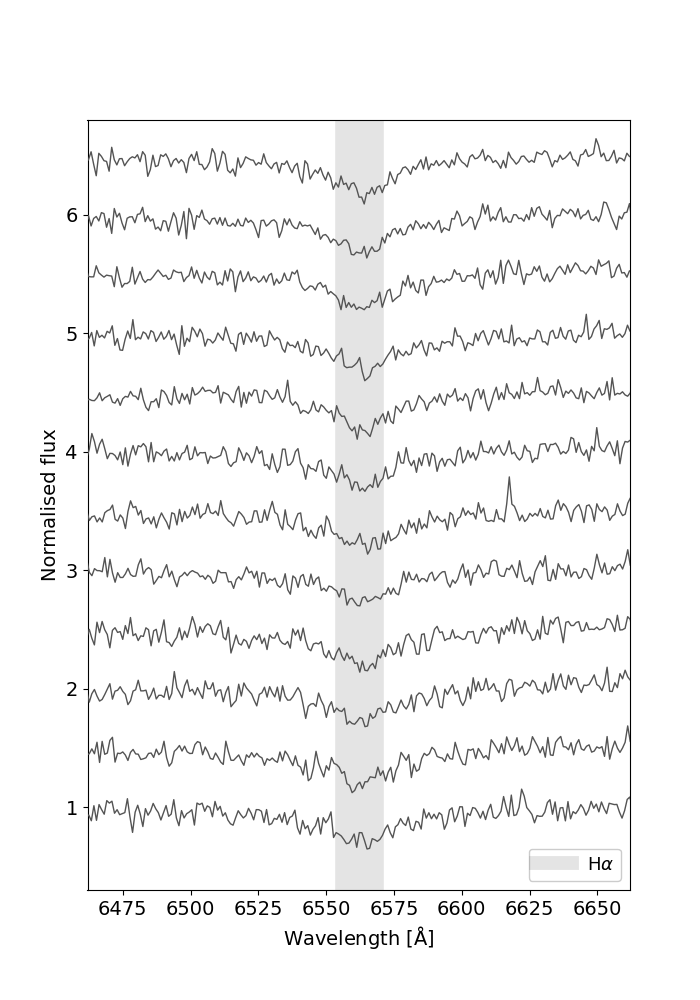

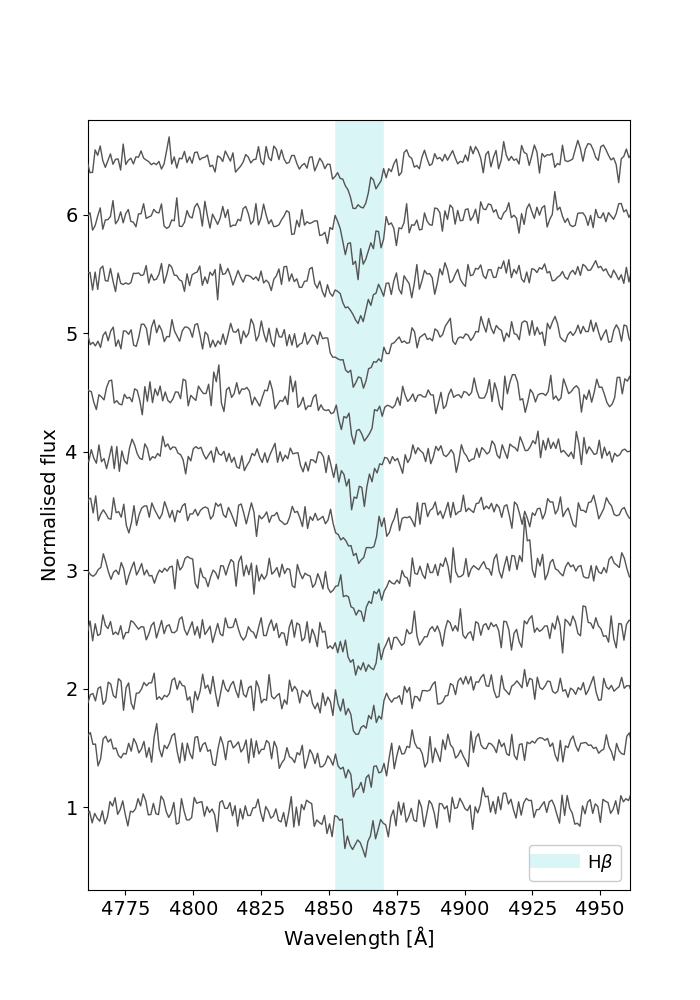

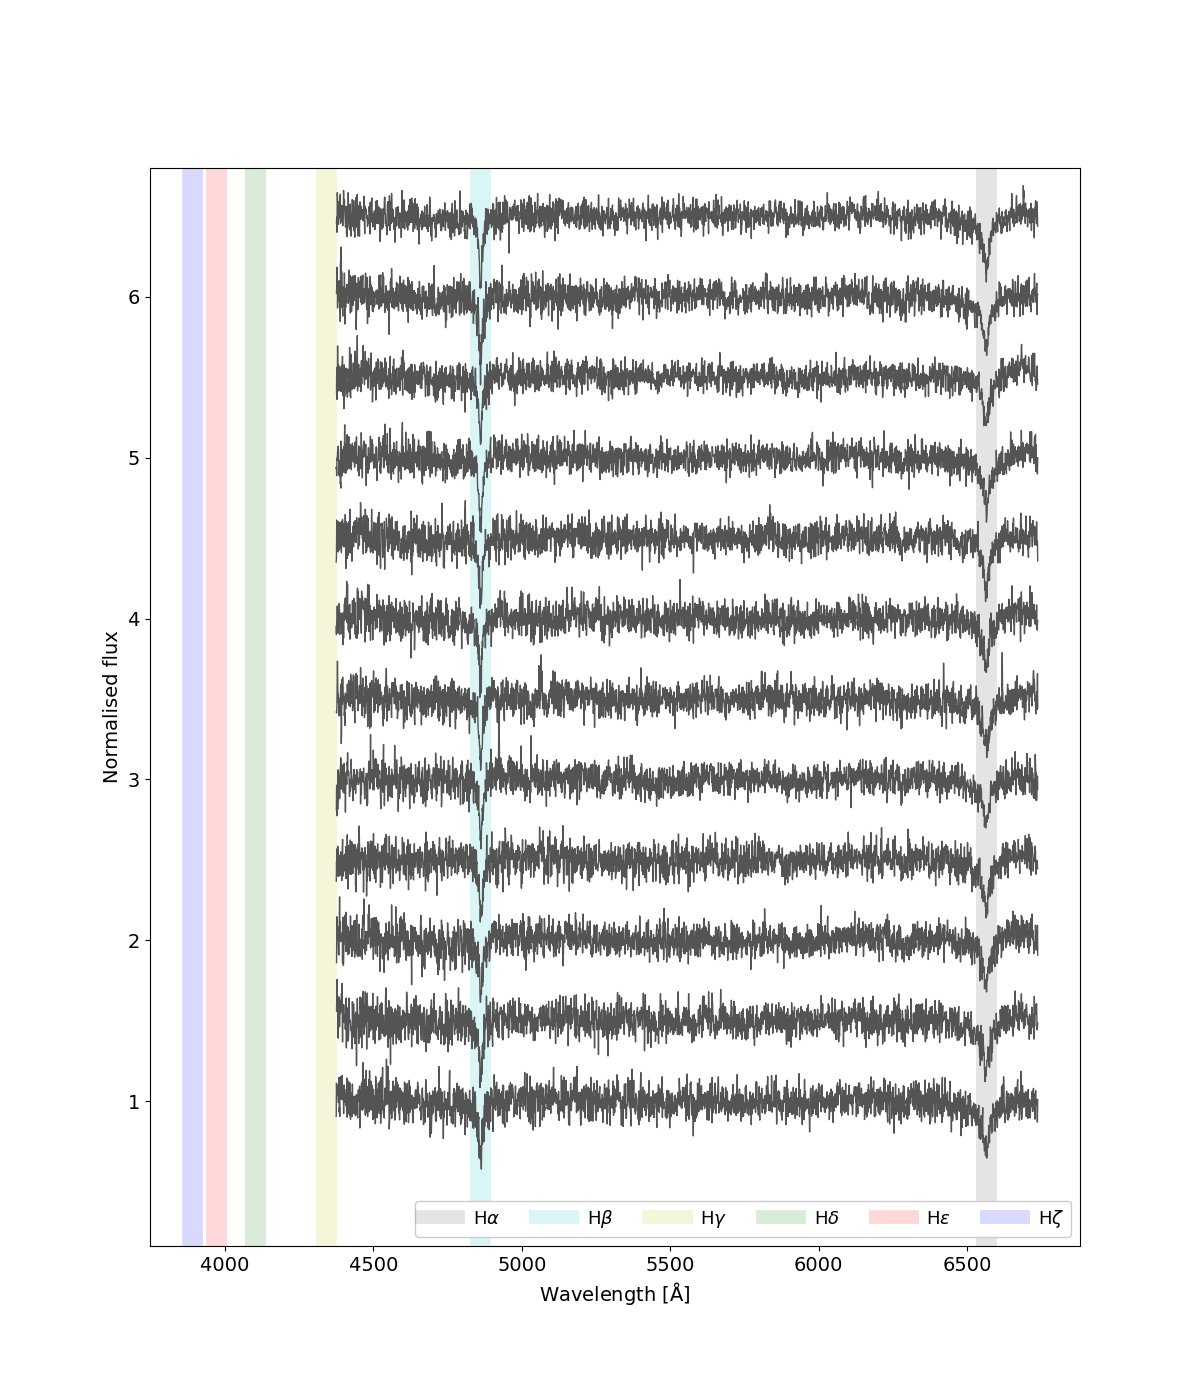

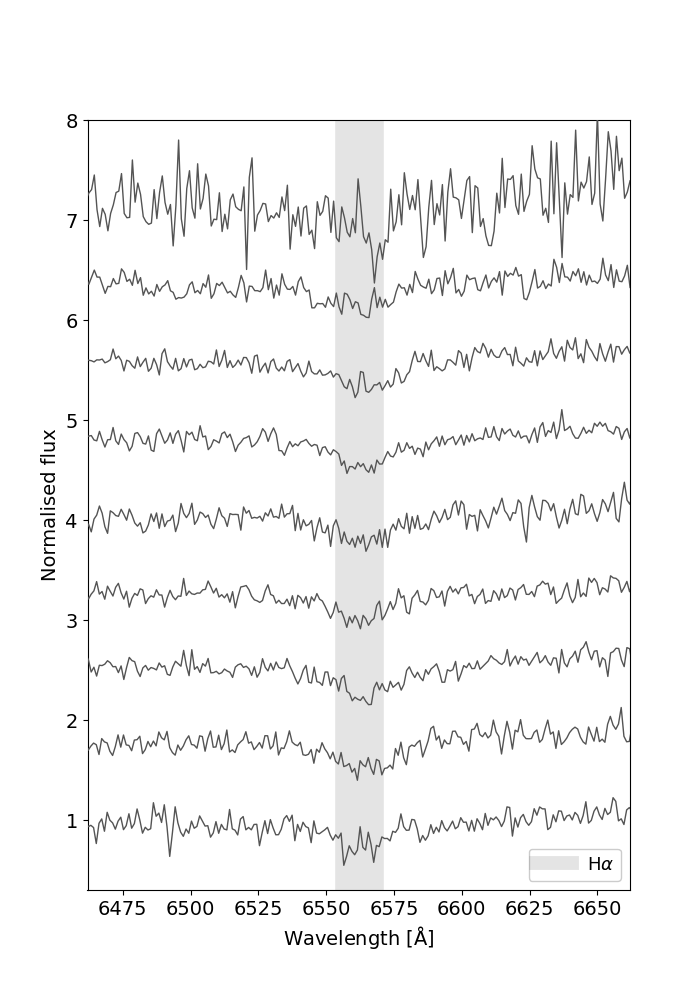

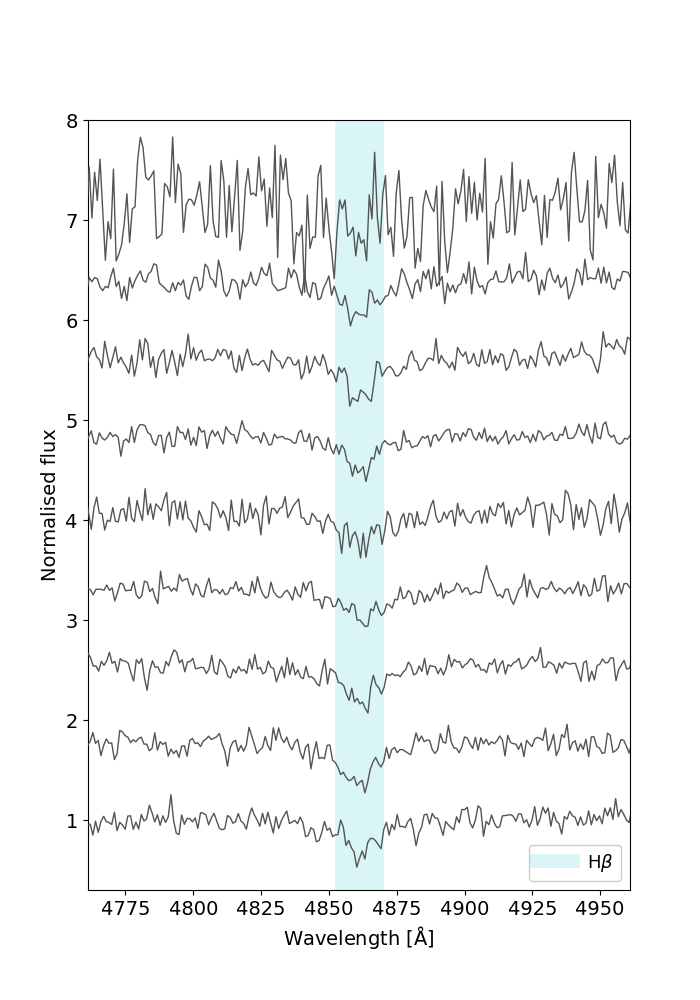

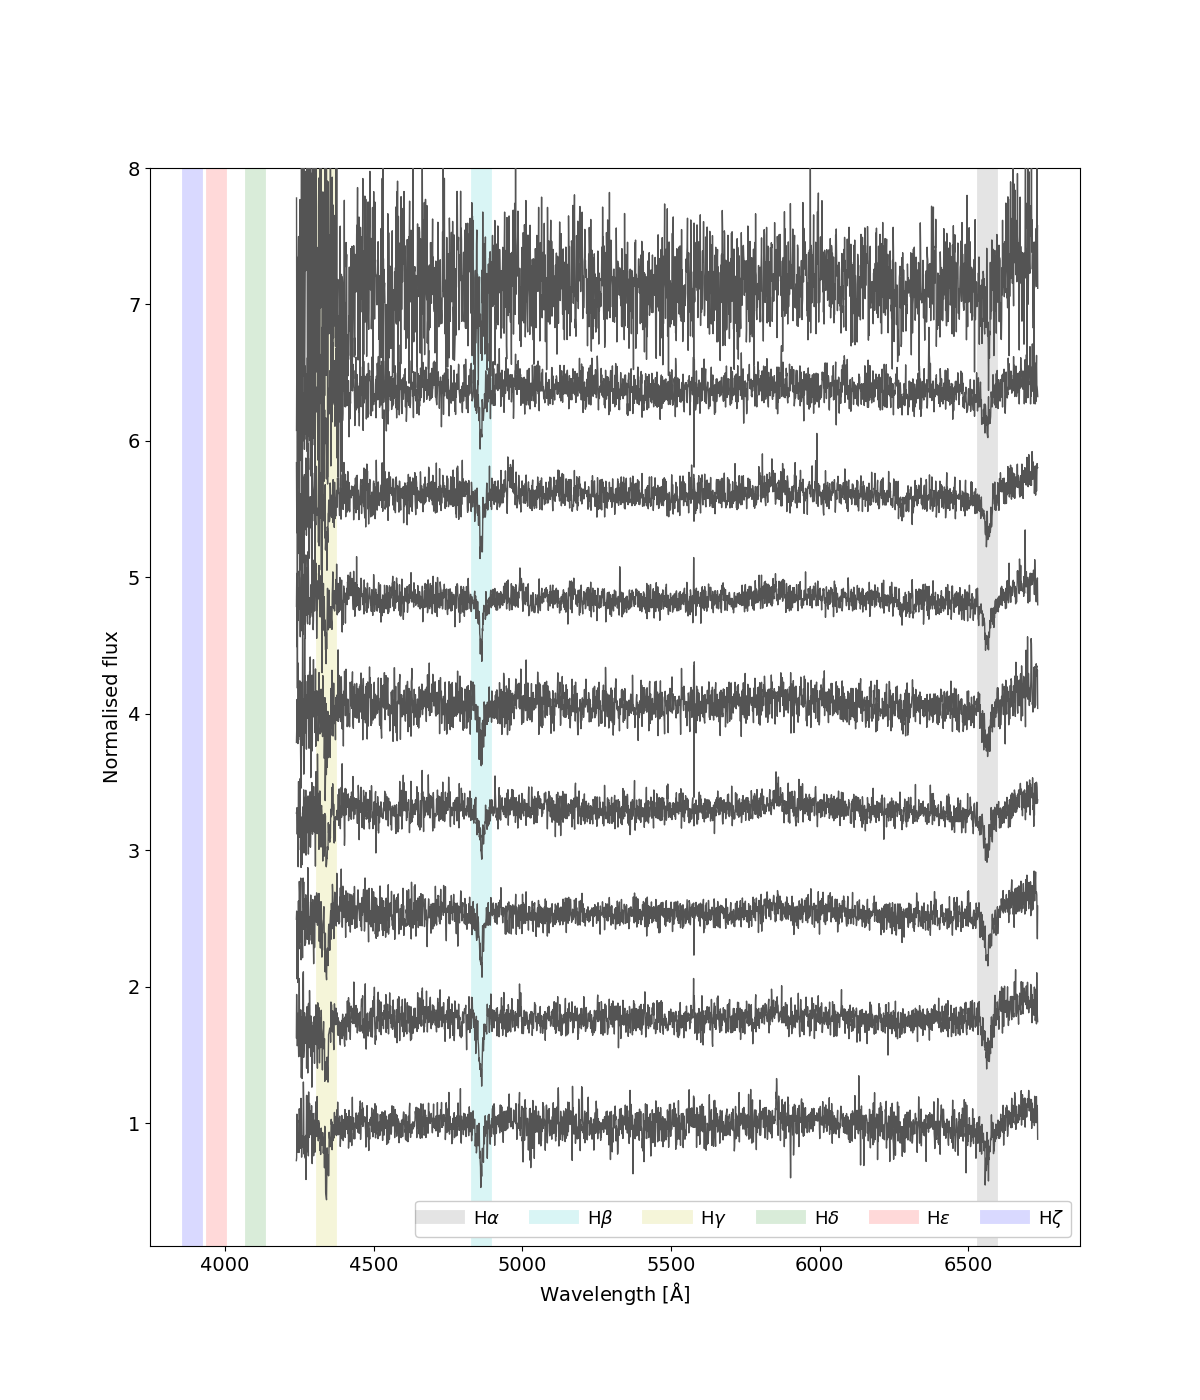

In [ ]:
# The columns are wavelength (AA), millijansky, millijansky error

# Inside of the folders are the spectra and a png of the spectra
# All spectra have been flux calibrated. 
# You will find 1 star in each that is not J1653-1001 which is a radial velocity standard if you want to use it. 
# Inside of the header of all .dat files are the details of the exposure which should be self-explanatory.

# All spectra are around S/N of 20-30. It's time series, so of course some could be stacked for plotting purposes.


def read_INT_dat_files(file):
    INT_header = pd.read_csv(file, sep=r'\s+', nrows=0)
    INT_data = pd.read_csv(file, names=['Wavelength', 'Flux', 'Error'], sep=r'\s+', skiprows=1)
    
    return INT_header, INT_data

def plot_all_INT_data(file_selection):
    INT_file_selection = natsorted(glob.glob(file_selection))
    print(INT_file_selection)
        
    fig, ax = plt.subplots(figsize=(7, 14))
    plt.xlabel(r'Wavelength [$\mathrm{\AA}$]')
    plt.ylabel('Flux')
    plt.xlim([6400, 6720])
    plt.ylim([1, 17.5])
    plt.axvline(x=6562, lw=40, color='#505050', alpha=0.15)

    for INT_file, i in zip(INT_file_selection, np.linspace(0, 14, 12)):
        file_header, file = read_INT_dat_files(INT_file)

        ax.plot(file['Wavelength'], file['Flux']+i, color='dimgrey', lw=1)

def normalised_convolved_spectrum_INT_dat_file(file_selection, no_of_spectra, figsize, ylim, balmer=None, spacing=2, fwhm=1/1, draw_style='default'):
    file_selection = natsorted(glob.glob(file_selection))

    fig, ax = plt.subplots(figsize=figsize)
    if balmer==None:
        plt.xlim()
        plt.ylim(ylim)
        balmer_lines(15)
        marker_size = 10
        spacing = spacing
    else:
        x, lw, color, alpha, label, xlim = balmer
        plt.axvline(x=x, lw=lw, color=color, alpha=alpha, label=label)
        plt.xlim(xlim)
        plt.ylim(ylim)
        marker_size = 10
    
    plt.xlabel(r'Wavelength [$\mathrm{\AA}$]')
    plt.ylabel('Normalised flux')

    add_legend(ax, 6, marker_size)

    for file, i in zip(file_selection, np.linspace(0, no_of_spectra/spacing, no_of_spectra+1)):
        data_header, data = read_INT_dat_files(file)
        wavelength_col = data['Wavelength']
        flux_col = data['Flux']
        spectrum_edges_and_spec_lines = [SpectralRegion(6400*u.AA, 6720*u.AA), SpectralRegion(4760*u.AA, 4960*u.AA), SpectralRegion(4240*u.AA, 4440*u.AA)]

        convolved_flux = convolve_observed_spectra(flux_col, FWHM=fwhm)
        spectrum_with_convolved_wavelengths_and_fluxes = spectrum_object_no_err(wavelength_col, convolved_flux)
        spectrum_with_convolved_wavelengths_and_fluxes_y_continuum_fitted, spectrum_with_convolved_wavelengths_and_fluxes_normalised = continuum_fitted_spectrum(spectrum_with_convolved_wavelengths_and_fluxes, wavelength_col, spectrum_edges_and_spec_lines)

        ax.plot(spectrum_with_convolved_wavelengths_and_fluxes_normalised.spectral_axis, spectrum_with_convolved_wavelengths_and_fluxes_normalised.flux+i, '-', linewidth=1, color='#545454', zorder=20, drawstyle=draw_style) 
    
    return fig, ax, spectrum_with_convolved_wavelengths_and_fluxes_normalised.flux



# June 2023
INT_header_20230619, INT_data_20230619 = read_INT_dat_files('Abbi_J1653-1001/abbi_20230619/spectrum2023_J1653-1001_6_2460115.432881388.dat')

# plot_all_INT_data('Abbi_J1653-1001/abbi_20230619/*.dat')

INT_20230619_normalised_convolved_Ha_fig, INT_20230619_normalised_convolved_Ha_ax, INT_20230619_normalised_convolved_Ha_flux = normalised_convolved_spectrum_INT_dat_file('Abbi_J1653-1001/abbi_20230619/*.dat', 12, (7,10), [0.3,6.8], H_alpha())
INT_20230619_normalised_convolved_Hb_fig, INT_20230619_normalised_convolved_Hb_ax, INT_20230619_normalised_convolved_Hb_flux = normalised_convolved_spectrum_INT_dat_file('Abbi_J1653-1001/abbi_20230619/*.dat', 12, (7,10), [0.3,6.8], H_beta())

INT_20230619_normalised_convolved_fig, INT_20230619_normalised_convolved_ax, INT_normalised20230619__convolved_flux = normalised_convolved_spectrum_INT_dat_file('Abbi_J1653-1001/abbi_20230619/*.dat', 12, (12,14), [0.1,6.8])


# July 2023
INT_header_20230718, INT_data_20230718 = read_INT_dat_files('Abbi_J1653-1001/abbi_20230718/spectrum2023_J1653-1001_3_2460144.4671509364.dat')

# plot_all_INT_data('Abbi_J1653-1001/abbi_20230718/*.dat')

INT_20230718_normalised_convolved_Ha_fig, INT_20230718_normalised_convolved_Ha_ax, INT_20230718_normalised_convolved_Ha_flux = normalised_convolved_spectrum_INT_dat_file('Abbi_J1653-1001/abbi_20230718/*.dat', 9, (7,10), [0.3,8], H_alpha(), spacing=1.3)
INT_20230718_normalised_convolved_Hb_fig, INT_20230718_normalised_convolved_Hb_ax, INT_20230718_normalised_convolved_Hb_flux = normalised_convolved_spectrum_INT_dat_file('Abbi_J1653-1001/abbi_20230718/*.dat', 9, (7,10), [0.3,8], H_beta(), spacing=1.3)

INT_20230718_normalised_convolved_fig, INT_20230718_normalised_convolved_ax, INT_normalised20230718__convolved_flux = normalised_convolved_spectrum_INT_dat_file('Abbi_J1653-1001/abbi_20230718/*.dat', 9, (12,14), [0.1,8], spacing=1.3)

<br>

# Mike 2023
- 19/20-Jul-2023     gaia_4334641562477923712_mike.txt

<br>

# MagE 2024
- 10/11-Jul_2022     wdj1653-1001_coadd.fits

<br>

# FORS2 2024
- 17/18-May-2024	02:51:44 > 03:50:11     2024-05-18T0325
- 5/6-Jun-2024	    00:24:27 > 01:24:32     2024-06-06_subexposures and 2024-06-06T00_59_30.dat
- 15/16-Jun-2024	00:25:09 > 01:24:55     2024-06-16UT01_00
- 3/4-Jul-2024	    01:50:48 > 02:50:20     2024-07-04UT02_25
- 13/14-Jul-2024	23:26:28 > 00:29:40     2024-07-14_UT00_05
- 14/15-Jul-2024	23:28:11 > 00:30:25     2024-07-15_UT00_05

Time at midexposures are as follows (sorry if I am lazy, I do not add the 165s by myself…. the time stamp is the time at which the shutter opens, then add half exposure time).
- 01 2024-06-06T00:34:51.164  +165s 
- 02 2024-06-06T00:41:20.873 +165s 
- 03 2024-06-06T00:47:18.460 +155s 
- 04 2024-06-06T00:53:46.889 +165s 
- 05 2024-06-06T00:59:44.465 +165s 
- 06 2024-06-06T01:06:12.894 +165s 
- 07 2024-06-06T01:12:10.480 +165s 
- 08 2024-06-06T01:18:39.889 +165s 

In [149]:
# Wavelength is in AA, Intensity is in units of electrons
# Stokes V/I error is a rough estimate of the photon noise error
# The null profile is N_V
FORS2_cols = ['Wavelength', 'Intensity', 'Intensity_error', 'Stokes_V/I', 'Stokes_V/I_error', 'Null_profile(N_V)']
FORS2_subexposures_cols = ['Wavelength', 'Intensity', 'Intensity_error']


# 17/18 May
FORS2_2024_05_18T0325_001 = pd.read_csv('FORS2_2024/2024-05-18T0325/Profiles_001.dat', names=FORS2_cols, sep=r'\s+')
FORS2_2024_05_18T0325_002 = pd.read_csv('FORS2_2024/2024-05-18T0325/Profiles_002.dat', names=FORS2_cols, sep=r'\s+')
FORS2_2024_05_18T0325_004 = pd.read_csv('FORS2_2024/2024-05-18T0325/Profiles_004.dat', names=FORS2_cols, sep=r'\s+')
FORS2_2024_05_18T0325_008 = pd.read_csv('FORS2_2024/2024-05-18T0325/Profiles_008.dat', names=FORS2_cols, sep=r'\s+')
FORS2_2024_05_18T0325_016 = pd.read_csv('FORS2_2024/2024-05-18T0325/Profiles_016.dat', names=FORS2_cols, sep=r'\s+')
FORS2_2024_05_18T0325_032 = pd.read_csv('FORS2_2024/2024-05-18T0325/Profiles_032.dat', names=FORS2_cols, sep=r'\s+')
FORS2_2024_05_18T0325_064 = pd.read_csv('FORS2_2024/2024-05-18T0325/Profiles_064.dat', names=FORS2_cols, sep=r'\s+')
FORS2_2024_05_18T0325_128 = pd.read_csv('FORS2_2024/2024-05-18T0325/Profiles_128.dat', names=FORS2_cols, sep=r'\s+')
FORS2_2024_05_18T0325_256 = pd.read_csv('FORS2_2024/2024-05-18T0325/Profiles_256.dat', names=FORS2_cols, sep=r'\s+')

# 5/6 June
FORS2_2024_06_06_subexposures_01 = pd.read_csv('FORS2_2024/2024-06-06_subexposures/01.dat', names=FORS2_subexposures_cols, sep=r'\s+')
FORS2_2024_06_06_subexposures_02 = pd.read_csv('FORS2_2024/2024-06-06_subexposures/02.dat', names=FORS2_subexposures_cols, sep=r'\s+')
FORS2_2024_06_06_subexposures_03 = pd.read_csv('FORS2_2024/2024-06-06_subexposures/03.dat', names=FORS2_subexposures_cols, sep=r'\s+')
FORS2_2024_06_06_subexposures_04 = pd.read_csv('FORS2_2024/2024-06-06_subexposures/04.dat', names=FORS2_subexposures_cols, sep=r'\s+')
FORS2_2024_06_06_subexposures_05 = pd.read_csv('FORS2_2024/2024-06-06_subexposures/05.dat', names=FORS2_subexposures_cols, sep=r'\s+')
FORS2_2024_06_06_subexposures_06 = pd.read_csv('FORS2_2024/2024-06-06_subexposures/06.dat', names=FORS2_subexposures_cols, sep=r'\s+')
FORS2_2024_06_06_subexposures_07 = pd.read_csv('FORS2_2024/2024-06-06_subexposures/07.dat', names=FORS2_subexposures_cols, sep=r'\s+')
FORS2_2024_06_06_subexposures_08 = pd.read_csv('FORS2_2024/2024-06-06_subexposures/08.dat', names=FORS2_subexposures_cols, sep=r'\s+')

FORS2_2024_06_06_T00_59_30 = pd.read_csv('FORS2_2024/2024-06-06_subexposures/2024-06-06T00_59_30.dat', names=FORS2_cols, sep=r'\s+')




In [150]:
FORS2_2024_05_18T0325_001

,Wavelength,Intensity,Intensity_error,Stokes_V/I,Stokes_V/I_error,Null_profile(N_V)
0,5751.14,16.0,4.0,0.0,0.25,0.0
1,5751.90,16.0,4.0,0.0,0.25,0.0
2,5752.66,16.0,4.0,0.0,0.25,0.0
3,5753.42,16.0,4.0,0.0,0.25,0.0
4,5754.18,16.0,4.0,0.0,0.25,0.0
...,...,...,...,...,...,...
2046,7306.10,16.0,4.0,0.0,0.25,0.0
2047,7306.86,16.0,4.0,0.0,0.25,0.0
2048,7307.62,16.0,4.0,0.0,0.25,0.0
2049,7308.38,16.0,4.0,0.0,0.25,0.0


/var/folders/yz/wqxp3d411z77rzy166tkx3b80000gp/T/ipykernel_91503/1973063564.py:97: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i in leg.legendHandles:


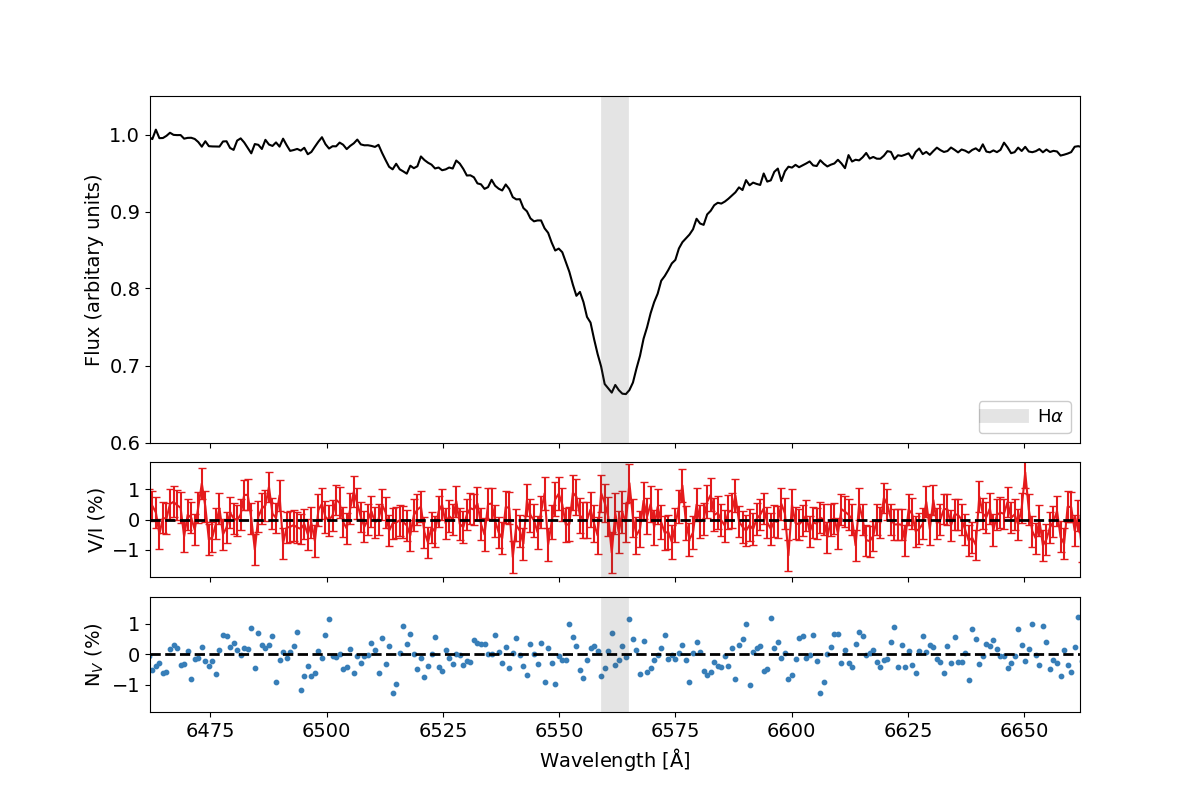

In [ ]:
fig_FORS2_2024_05_18T0325_001, (ax_flux_FORS2_2024_05_18T0325_001, ax_VI_FORS2_2024_05_18T0325_001, ax_Nv_FORS2_2024_05_18T0325_001) = plt.subplots(figsize=(12,8), gridspec_kw={'height_ratios': [3, 1, 1], 'hspace': 0.1}, nrows=3, sharex=True)

ax_flux_FORS2_2024_05_18T0325_001.plot(FORS2_2024_05_18T0325_001['Wavelength'], FORS2_2024_05_18T0325_001['Intensity']/56900, c='k')
ax_VI_FORS2_2024_05_18T0325_001.errorbar(FORS2_2024_05_18T0325_001['Wavelength'], FORS2_2024_05_18T0325_001['Stokes_V/I']*100, yerr=FORS2_2024_05_18T0325_001['Stokes_V/I_error']*100, capsize=3, c='#e41a1c')
ax_Nv_FORS2_2024_05_18T0325_001.scatter(FORS2_2024_05_18T0325_001['Wavelength'], FORS2_2024_05_18T0325_001['Null_profile(N_V)']*100, s=10, c='#377eb8')

plt.xlabel(r'Wavelength [$\mathrm{\AA}$]')

ax_flux_FORS2_2024_05_18T0325_001.set_ylabel('Flux (arbitary units)')
ax_VI_FORS2_2024_05_18T0325_001.set_ylabel('V/I (%)')
ax_Nv_FORS2_2024_05_18T0325_001.set_ylabel(r'N$_V$ (%)')

plt.xlim(6462, 6662)

ax_flux_FORS2_2024_05_18T0325_001.set_ylim(0.6, 1.05)
ax_VI_FORS2_2024_05_18T0325_001.set_ylim(-1.9, 1.9)
ax_Nv_FORS2_2024_05_18T0325_001.set_ylim(-1.9, 1.9)

ax_flux_FORS2_2024_05_18T0325_001.axvline(x=6562, lw=20, color='#505050', alpha=0.15, label=r'H$\alpha$')
ax_VI_FORS2_2024_05_18T0325_001.axvline(x=6562, lw=20, color='#505050', alpha=0.15, label=r'H$\alpha$')
ax_Nv_FORS2_2024_05_18T0325_001.axvline(x=6562, lw=20, color='#505050', alpha=0.15, label=r'H$\alpha$')

ax_VI_FORS2_2024_05_18T0325_001.axhline(0, ls='--', c='k', lw=2,zorder=100)
ax_Nv_FORS2_2024_05_18T0325_001.axhline(0, ls='--', c='k', lw=2,zorder=100)

add_legend(ax_flux_FORS2_2024_05_18T0325_001, 1, 10, loc='lower right')

# plt.savefig('FORS2_2024/2024-05-18T0325/Plots/FORS2_2024_05_18T0325_001.pdf', bbox_inches='tight')


/var/folders/yz/wqxp3d411z77rzy166tkx3b80000gp/T/ipykernel_91503/1973063564.py:97: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i in leg.legendHandles:


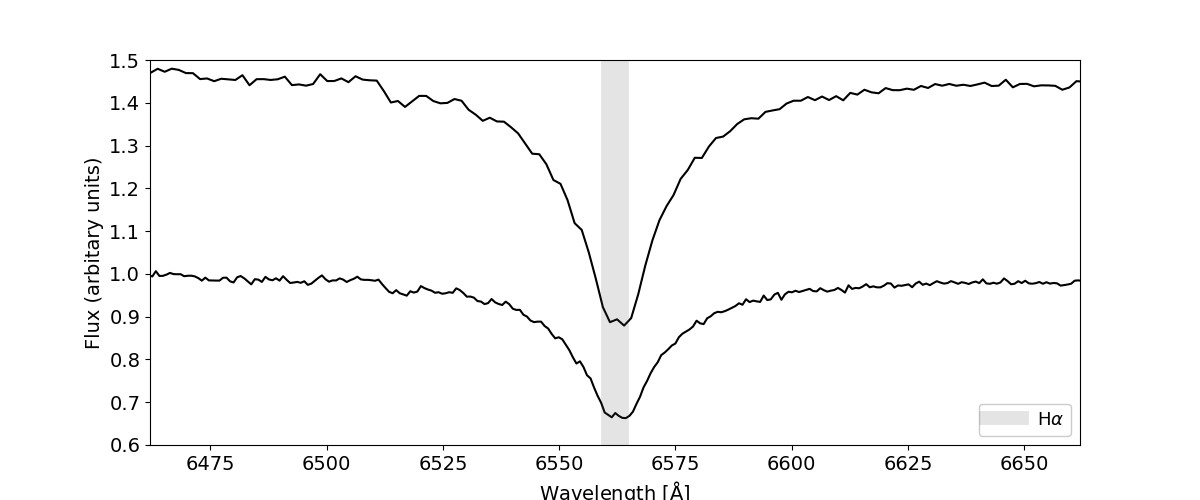

In [ ]:
fig_FORS2_2024_05_18T0325_001, ax_flux_FORS2_2024_05_18T0325_001_002 = plt.subplots(figsize=(12,5))

ax_flux_FORS2_2024_05_18T0325_001_002.plot(FORS2_2024_05_18T0325_001['Wavelength'], FORS2_2024_05_18T0325_001['Intensity']/56900, c='k')
ax_flux_FORS2_2024_05_18T0325_001_002.plot(FORS2_2024_05_18T0325_002['Wavelength'], (FORS2_2024_05_18T0325_002['Intensity']/64000)-0.3, c='k')

plt.xlabel(r'Wavelength [$\mathrm{\AA}$]')
ax_flux_FORS2_2024_05_18T0325_001_002.set_ylabel('Flux (arbitary units)')

plt.xlim(6462, 6662)
ax_flux_FORS2_2024_05_18T0325_001_002.set_ylim(0.6, 1.5)

ax_flux_FORS2_2024_05_18T0325_001_002.axvline(x=6562, lw=20, color='#505050', alpha=0.15, label=r'H$\alpha$')

add_legend(ax_flux_FORS2_2024_05_18T0325_001_002, 1, 10, loc='lower right')

# plt.savefig('FORS2_2024/2024-05-18T0325/Plots/FORS2_2024_05_18T0325_001_002.pdf', bbox_inches='tight')

In [ ]:
def read_FORS2_dat_files(file):
    FORS2_data = pd.read_csv(file, names=FORS2_cols, sep=r'\s+')
    
    return FORS2_data

def plot_all_FORS2_data(file_selection):
    FORS2_file_selection = natsorted(glob.glob(file_selection))
    print(FORS2_file_selection)
        
    fig, ax = plt.subplots(figsize=(7, 14))
    plt.xlabel(r'Wavelength [$\mathrm{\AA}$]')
    plt.ylabel('Flux (arbitary units)')
    plt.xlim([6462, 6662])
    # plt.ylim([1, 17.5])
    plt.axvline(x=6562, lw=40, color='#505050', alpha=0.15)

    for FORS2_file, i in zip(FORS2_file_selection, np.linspace(0, 8, 8)):
        file = read_FORS2_dat_files(FORS2_file)

        ax.plot(file['Wavelength'], (file['Intensity']/56900)+i, color='dimgrey', lw=1)

['FORS2_2024/2024-05-18T0325/Profiles_001.dat', 'FORS2_2024/2024-05-18T0325/Profiles_002.dat', 'FORS2_2024/2024-05-18T0325/Profiles_004.dat', 'FORS2_2024/2024-05-18T0325/Profiles_008.dat', 'FORS2_2024/2024-05-18T0325/Profiles_016.dat', 'FORS2_2024/2024-05-18T0325/Profiles_032.dat', 'FORS2_2024/2024-05-18T0325/Profiles_064.dat', 'FORS2_2024/2024-05-18T0325/Profiles_128.dat', 'FORS2_2024/2024-05-18T0325/Profiles_256.dat']


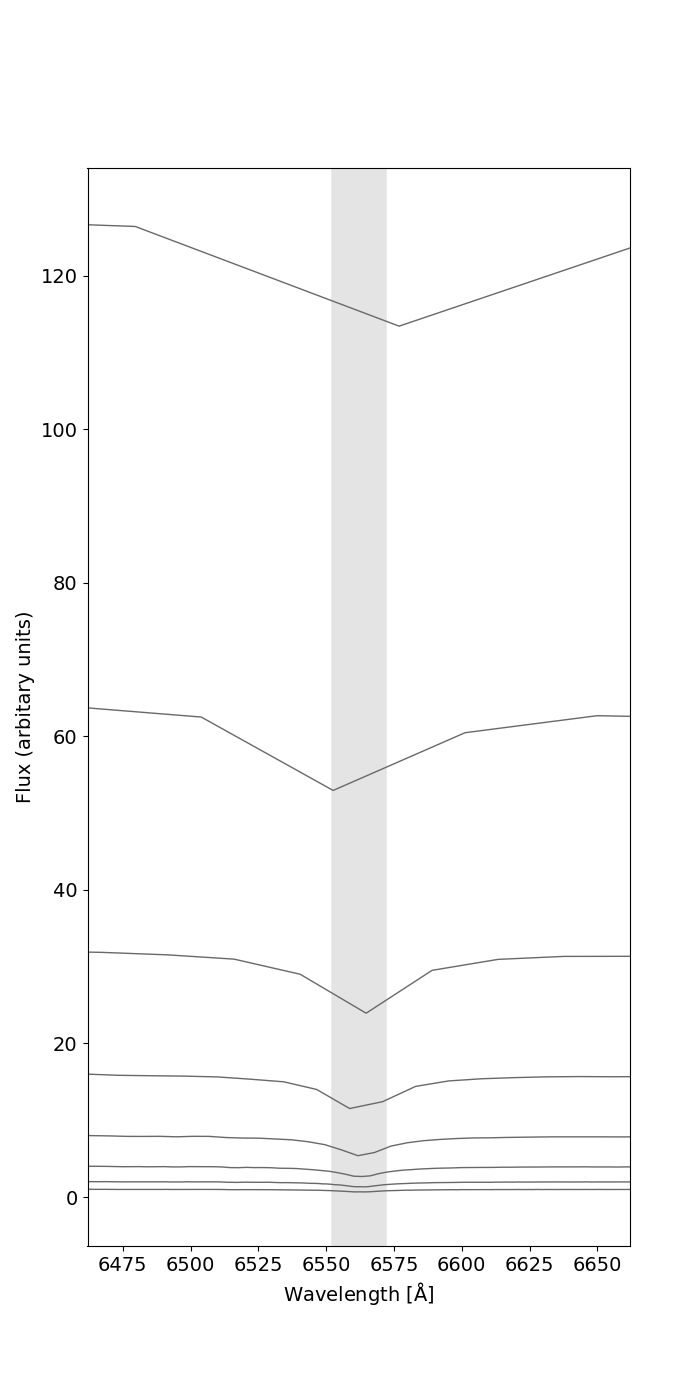

In [184]:
plot_all_FORS2_data('FORS2_2024/2024-05-18T0325/*.dat')

In [180]:
np.linspace(0, 8, 8)

array([0.        , 1.14285714, 2.28571429, 3.42857143, 4.57142857,
       5.71428571, 6.85714286, 8.        ])

In [187]:
FORS2_2024_05_18T0325_256

,Wavelength,Intensity,Intensity_error,Stokes_V/I,Stokes_V/I_error,Null_profile(N_V)
0,6041.84,12531300.0,4258.56,-0.000437,0.000340,-0.000310
1,6236.40,13932800.0,4552.14,0.000314,0.000327,-0.000567
2,6430.96,14453100.0,4587.97,0.000005,0.000317,0.000477
3,6625.52,13567600.0,4437.91,-0.000045,0.000327,-0.000236
4,6820.08,13167800.0,4352.48,0.000172,0.000331,0.000661
5,7014.64,11731300.0,4113.96,-0.000692,0.000351,-0.000755
6,7209.20,8831200.0,3616.28,-0.000661,0.000409,0.000031


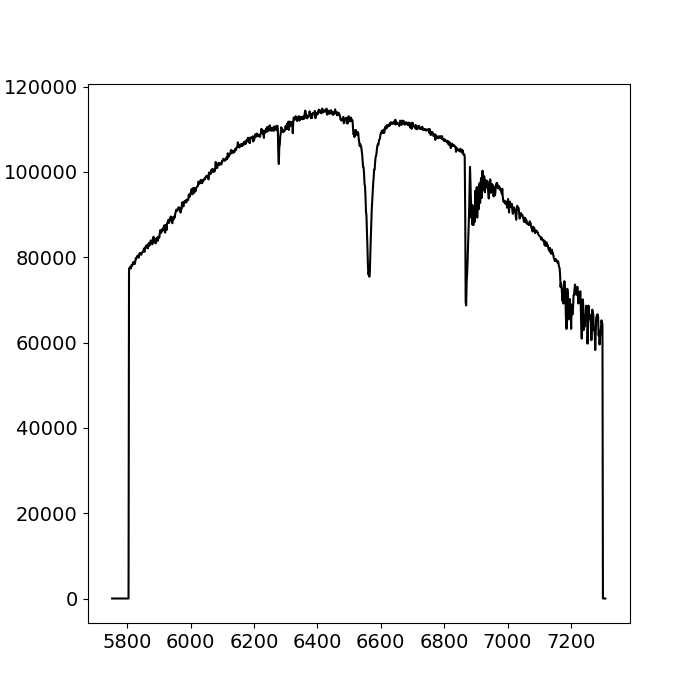

In [194]:
fig, ax = plt.subplots()

ax.plot(FORS2_2024_05_18T0325_002['Wavelength'], FORS2_2024_05_18T0325_002['Intensity'], c='k')


In [ ]:
FORS2_2024_05_18T0325_001 = pd.read_csv('FORS2_2024/2024-05-18T0325/Profiles_001.dat', names=FORS2_cols, sep=r'\s+')
FORS2_2024_05_18T0325_002 = pd.read_csv('FORS2_2024/2024-05-18T0325/Profiles_002.dat', names=FORS2_cols, sep=r'\s+')
FORS2_2024_05_18T0325_004 = pd.read_csv('FORS2_2024/2024-05-18T0325/Profiles_004.dat', names=FORS2_cols, sep=r'\s+')
FORS2_2024_05_18T0325_008 = pd.read_csv('FORS2_2024/2024-05-18T0325/Profiles_008.dat', names=FORS2_cols, sep=r'\s+')
FORS2_2024_05_18T0325_016 = pd.read_csv('FORS2_2024/2024-05-18T0325/Profiles_016.dat', names=FORS2_cols, sep=r'\s+')
FORS2_2024_05_18T0325_032 = pd.read_csv('FORS2_2024/2024-05-18T0325/Profiles_032.dat', names=FORS2_cols, sep=r'\s+')
FORS2_2024_05_18T0325_064 = pd.read_csv('FORS2_2024/2024-05-18T0325/Profiles_064.dat', names=FORS2_cols, sep=r'\s+')
FORS2_2024_05_18T0325_128 = pd.read_csv('FORS2_2024/2024-05-18T0325/Profiles_128.dat', names=FORS2_cols, sep=r'\s+')
FORS2_2024_05_18T0325_256 = pd.read_csv('FORS2_2024/2024-05-18T0325/Profiles_256.dat', names=FORS2_cols, sep=r'\s+')
